---
title: Sentinel-1 L2 OCN Zarr Product Exploration
subtitle: Explore how to open, visualise and use Sentinel-1 OCN products in EOPF Zarr format
authors:
  - name: Juraj Zvolensky
    orcid: 0009-0000-9185-7955
    github: jzvolensky
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-06-03
thumbnail: ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
keywords: ["xarray", "earth observation", "remote sensing"]
tags: ["sentinel-1", "xarray", "marine"]
releaseDate: 2025-06-03
datePublished: 2025-06-03
dateModified: 2025-06-03
github: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks
license: Apache-2.0
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

# Sentinel-1 L2 OCN Zarr Product Exploration

## Table of Contents

- [Introduction](#introduction)
- [Import modules](#import-modules)
- [Load and filter the data](#load-and-filter-the-data)
- [Examples of product usage](#examples-of-product-usage)
    - [Ocean Wind Field (OWI)](#ocean-wind-field-owi)
    - [Wind speed](#wind-speed)
    - [Wind direction](#wind-direction)
    - [Wind field in geographic projection](#wind-field-in-geographic-projection)
    - [Ocean Swell Wave (OSW)](#ocean-swell-wave-osw)
    - [Normalized Radar Cross Section (NRCS) averaged on OSW grid](#normalized-radar-cross-section-nrcs-averaged-on-osw-grid)
    - [Significant wave height](#significant-wave-height)
    - [Dominant Wave Length](#dominant-wave-length)
    - [Swell wave field in geographic projection](#swell-wave-field-in-geographic-projection)
    - [Swell Spectrum in polar coordinates](#swell-spectrum-in-polar-coordinates)
    - [Ocean Radial Velocity (RVL)](#ocean-radial-velocity-rvl)
    - [Radial velocity in geographic projection](#radial-velocity-in-geographic-projection)





(Introduction)=
## Introduction
In this notebook we will show examples of L2 OCN products and plotting examples with Xarray.

:::{hint} Overview
**Questions**
- How can I access Sentinel 1 L2 OCN products?
- How do I filter the data?
- How do I visualize the data?
- How do we compute different indices?

**Objectives**
- Being able to open a Sentinel 1 L2 OCN EOPF Zarr product from an object storage
- Understanding the structure of the product
- Being able to filter the data and perform computation of indices
:::

(import-modules)=
## Import Modules

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

(load-and-filter-the-data)=
## Load and filter the data 

In [2]:
s3_link = "https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S1A_S5_OCN__2SDV_20230315T185328_20230315T185357_047658_05B968_C2AE.zarr"

datatree = xr.open_datatree(s3_link, engine="zarr")

osw = datatree["osw"]
owi = datatree["owi"]
rvl = datatree["rvl"]

(examples-of-product-usage)=
## Examples of product usage


(ocean-wind-field-owi)=
### Ocean Wind Field (OWI)
**open data**

In [3]:
owi = owi["S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV"]

Access the polarisation group or variable within the OWI group

In [4]:
polarisation = owi.conditions["polarisation"]
polarisation

<xarray.DataArray 'polarisation' (polarisation: 2)> Size: 2B
array([0, 1], dtype=int8)
Coordinates:
  * polarisation  (polarisation) int8 2B 0 1
Attributes:
    dimensions:     ['polarisation']
    dtype:          <u1
    flag_meanings:  VV VH HH HV DH DV
    flag_values:    [0 1 2 3 4 5]
    long_name:      identifier of the receiving polarization in order to disc...

(wind-speed)=
### Wind speed

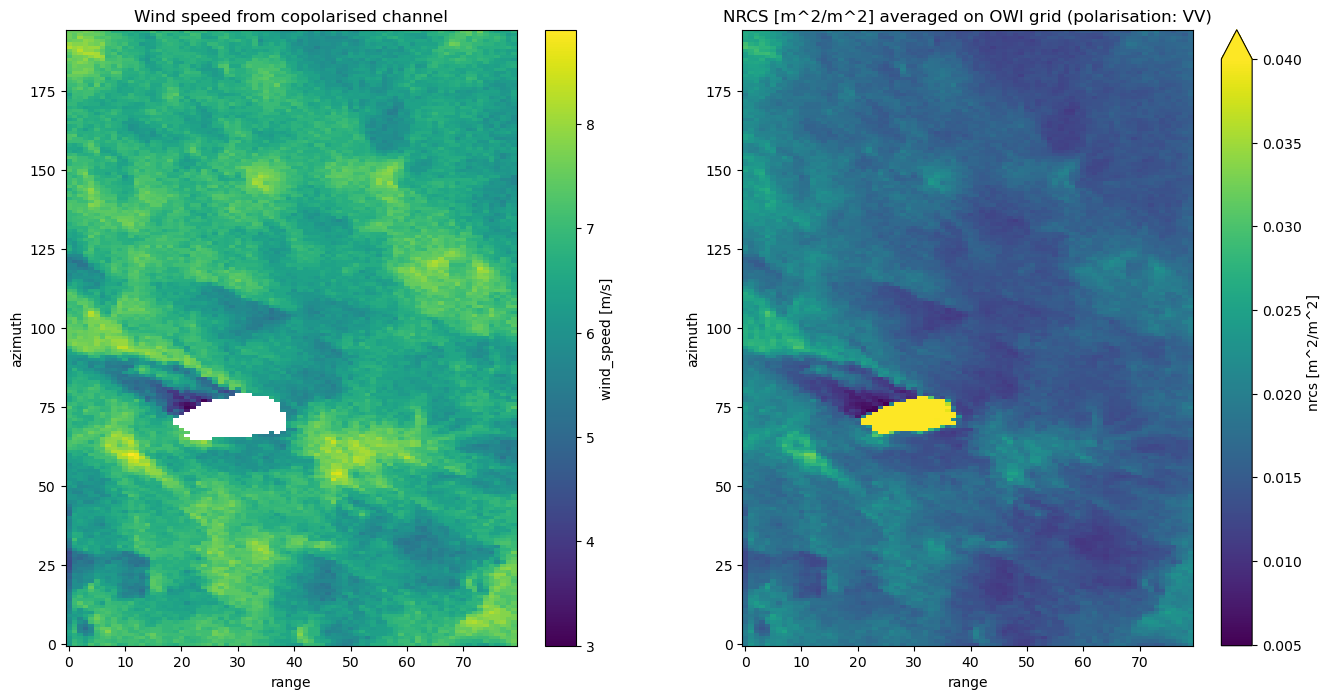

In [6]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
owi.measurements.wind_speed.plot(ax=ax[0])

polarisation_index = 0
owi.conditions.nrcs[..., polarisation_index].plot(ax=ax[1], vmax=0.04)
ax[0].set_title("Wind speed from copolarised channel")
ax[1].set_title(
    f"NRCS [m^2/m^2] averaged on OWI grid (polarisation: {polarisation.attrs['flag_meanings'].split()[polarisation_index]})"
)
plt.show()

(wind-direction)=
### Wind direction

Note that in the following plot wind directions are in meteorological convention (directions are measured clockwise from North) without taking into account the platform heading



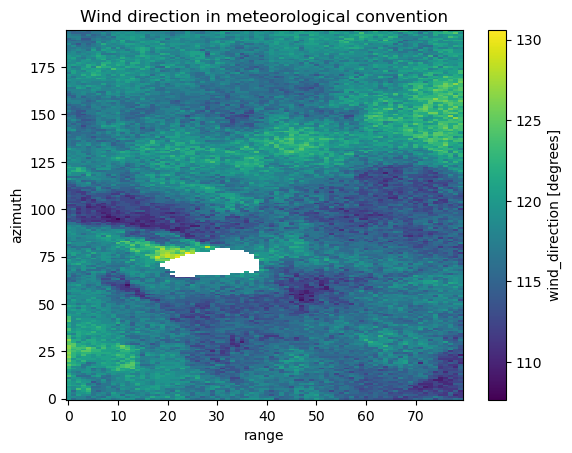

In [7]:
owi.measurements.wind_direction.plot()
plt.title("Wind direction in meteorological convention")
plt.show()

(wind-field-in-geographic-projection)=
### Wind field in geographic projection

Vectors can be plotted using the `plot.quiver` method, but `u` and `y` vector components are required as separate variables.

Wind data is provided as a pair of dataarrays:

   - `wind_speed:` wind vector module
   - `wind_direction:` angle of the wind vector in meteorological convention

The `matplotlib.pyplot.quiver` method can be used to plot vectors by computing `u` and `v` vector components.

`x` and `y` point coordinates can optionally be passed as arguments.

Providing `lat` and `lon` values projects the data onto geographical coordinates.

**Plot**

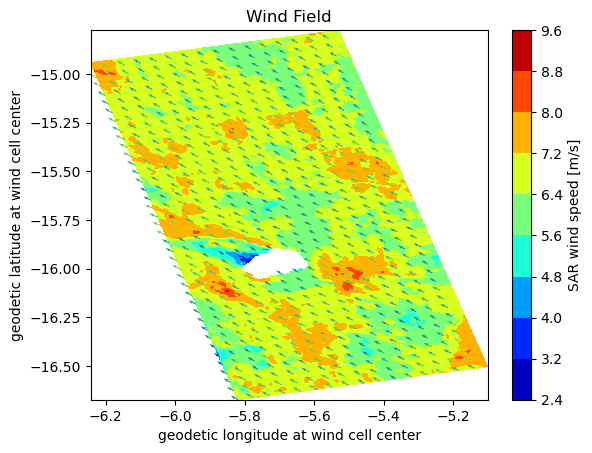

In [8]:
def get_vector_uv(norm, direction, heading=0):
    direction = (
        direction - heading
    )  # conversion from wind direction wrt north to wind direction wrt azimuth
    direction += 180.0  # conversion from meteorological to oceanographic conventions ("from where the wind comes" to "to where the wind goes")
    direction = (
        90 - direction
    )  # conversion from (z-axis, clockwise) angle to cartesian convention (x-axis, anti-clockwise))
    u = norm * np.cos(np.deg2rad(direction))
    v = norm * np.sin(np.deg2rad(direction))
    return u, v


stride = 5
wind_speed = owi.measurements.wind_speed[
    ::stride, ::stride
]  # also as the arrow color criterion
wind_dir = owi.measurements.wind_direction[::stride, ::stride]
u, v = get_vector_uv(wind_speed, wind_dir)
cp = plt.contourf(
    owi.measurements.longitude,
    owi.measurements.latitude,
    owi.measurements.wind_speed,
    cmap="jet",
)
plt.quiver(
    owi.measurements.longitude[::stride, ::stride],
    owi.measurements.latitude[::stride, ::stride],
    u,
    v,
    wind_speed,
)
cbar = plt.colorbar(cp)
cbar.ax.set_ylabel(
    owi.measurements.wind_speed._eopf_attrs["long_name"]
    + f" [{owi.measurements.wind_speed._eopf_attrs['units']}]"
)
plt.xlabel(owi.measurements.longitude.attrs["long_name"])
plt.ylabel(owi.measurements.latitude.attrs["long_name"])
plt.title("Wind Field")
plt.show()

(ocean-swell-wave-osw)=
### Ocean Swell Wave (OSW)

In [9]:
osw = osw["S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV"]
osw

<xarray.DataTree 'S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV'>
Group: /osw/S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV
│   Attributes:
│       other_metadata:  {'algorithm_version': 'S-1 OSW rev 1/4', 'bathymetry_sou...
│       stac_discovery:  {'assets': {}, 'bbox': [-5.086653, -16.678156, -6.249908...
├── Group: /osw/S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV/conditions
│       Dimensions:                             (azimuth: 11, range: 3, partition: 5,
│                                                lag: 3, ky: 185, kx: 128,
│                                                wavenumber_binsize: 60,
│                                                angular_binsize: 72)
│       Coordinates:
│           jx                                  (kx) float32 512B ...
│           jy                                  (ky) float32 740B ...
│           k                                   (wavenumber_binsize) float32 240B ...
│         * kx                                  (kx) float32 512B 0.0 ... 2.493e+04
│         * ky                                  (ky) float32 740B -8.673e+03 ... 8.67...
│           latitude                            (azimuth, range) float32 132B ...
│           longitude                           (azimuth, range) float32 132B ...
│           phi                                 (angular_binsize) float32 288B ...
│       Dimensions without coordinates: azimuth, range, partition, lag,
│                                       wavenumber_binsize, angular_binsize
│       Data variables: (12/28)
│           ambiguity_factor                    (azimuth, range, partition) float32 660B ...
│           auxiliary_wind_direction            (azimuth, range) float32 132B ...
│           auxiliary_wind_speed                (azimuth, range) float32 132B ...
│           azimuth_cutoff                      (azimuth, range) float32 132B ...
│           azimuth_size                        (azimuth, range) float32 132B ...
│           cartesian_spectra_imaginary         (azimuth, range, lag, ky, kx) float32 9MB ...
│           ...                                  ...
│           range_cutoff                        (azimuth, range) float32 132B ...
│           range_size_slc                      (azimuth, range) float32 132B ...
│           skewness                            (azimuth, range) float32 132B ...
│           spectrum_resolution                 (azimuth, range, angular_binsize) float32 10kB ...
│           wind_direction                      (azimuth, range) float32 132B ...
│           wind_speed                          (azimuth, range) float32 132B ...
├── Group: /osw/S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV/measurements
│       Dimensions:                      (azimuth: 11, range: 3, partition: 5,
│                                         wavenumber_binsize: 60, angular_binsize: 72)
│       Coordinates:
│           k                            (wavenumber_binsize) float32 240B ...
│           latitude                     (azimuth, range) float32 132B ...
│           longitude                    (azimuth, range) float32 132B ...
│           phi                          (angular_binsize) float32 288B ...
│       Dimensions without coordinates: azimuth, range, partition, wavenumber_binsize,
│                                       angular_binsize
│       Data variables:
│           hs                           (azimuth, range, partition) float32 660B ...
│           hs_normalised_variance       (azimuth, range, partition) float32 660B ...
│           partitions                   (azimuth, range, angular_binsize, wavenumber_binsize) float32 570kB ...
│           total_hs                     (azimuth, range) float32 132B ...
│           total_hs_standard_deviation  (azimuth, range) float32 132B ...
│           wave_age                     (azimuth, range) float32 132B ...
│           wave_direction               (azimuth, range, partition) float32 660B ...
│           wave_length                

(normalized-radar-cross-section-nrcs-averaged-on-osw-grid)=
### Normalized Radar Cross Section (NRCS) averaged on OSW grid

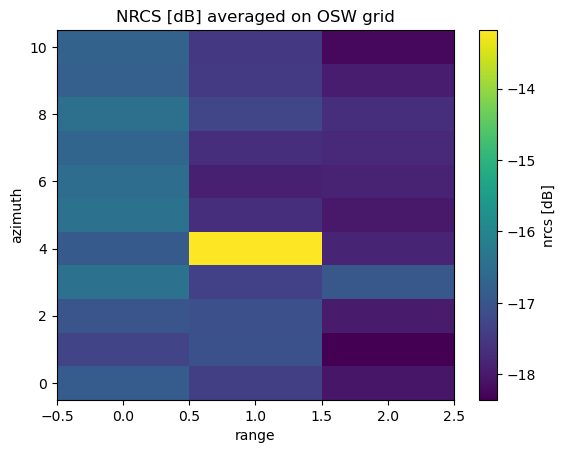

In [10]:
osw.conditions.nrcs.plot()
plt.title("NRCS [dB] averaged on OSW grid")
plt.show()

(significant-wave-height)=
### Significant wave height

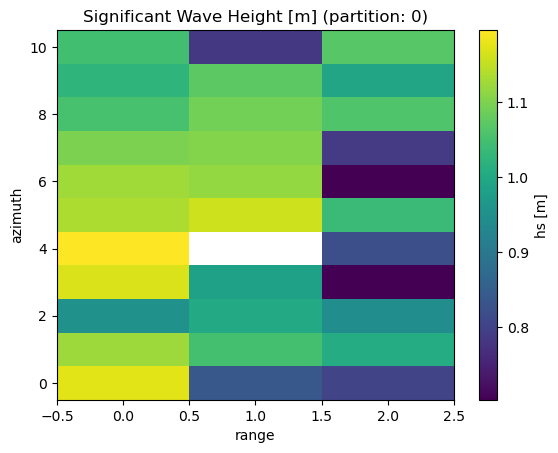

In [11]:
partition_index = 0
osw.measurements.hs[..., partition_index].plot()
plt.title(f"Significant Wave Height [m] (partition: {partition_index})")
plt.show()

(dominant-wave-length)=
### Dominant Wave Length


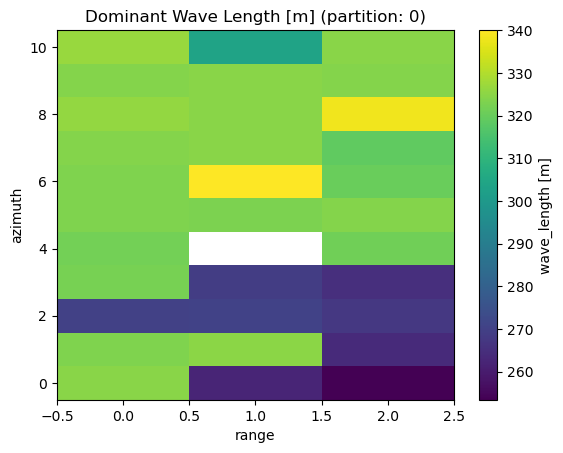

In [12]:
partition_index = 0
osw.measurements.wave_length[..., partition_index].plot()
plt.title(f"Dominant Wave Length [m] (partition: {partition_index})")
plt.show()

(swell-wave-field-in-geographic-projection)=
### Swell wave field in geographic projection

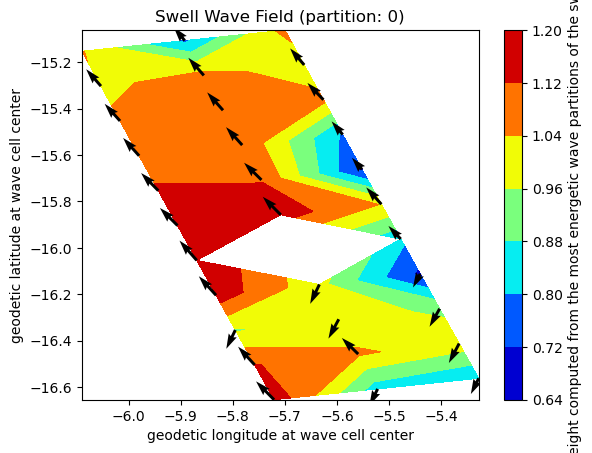

In [13]:
partition_index = 0
wave_direction = osw.measurements.wave_direction[..., partition_index]
wave_height = osw.measurements.hs[..., partition_index]
u, v = get_vector_uv(wave_height, wave_direction)
cp = plt.contourf(
    osw.measurements.longitude, osw.measurements.latitude, wave_height, cmap="jet"
)
cbar = plt.colorbar(cp)

plt.quiver(osw.measurements.longitude, osw.measurements.latitude, u, v, cmap="jet")
cbar.ax.set_ylabel(
    osw.measurements.hs._eopf_attrs["long_name"]
    + f" [{osw.measurements.hs.attrs['units']}]"
)
plt.xlabel(osw.measurements.longitude.attrs["long_name"])
plt.ylabel(osw.measurements.latitude.attrs["long_name"])
plt.title(f"Swell Wave Field (partition: {partition_index})")
plt.show()

(swell-spectrum-in-polar-coordinates)=
### Swell Spectrum in polar coordinates

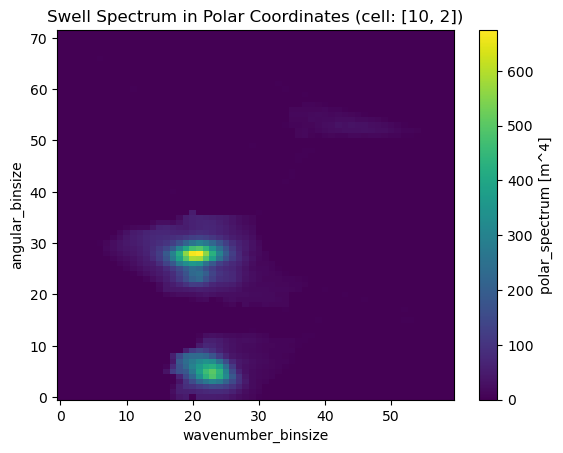

In [14]:
cell_index = 10, 2
osw.conditions.polar_spectrum[cell_index].plot()
plt.title(f"Swell Spectrum in Polar Coordinates (cell: {list(cell_index)})")
plt.show()

(ocean-radial-velocity-rvl)=
### Ocean Radial Velocity (RVL)

In [15]:
rvl = datatree["rvl"]
rvl = rvl["S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV"]
rvl

<xarray.DataTree 'S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV'>
Group: /rvl/S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV
│   Attributes:
│       other_metadata:  {'algorithm_version': 'S-1 RVL rev 1/5', 'clm_source': '...
│       stac_discovery:  {'assets': {}, 'bbox': [-5.086653, -16.678156, -6.249908...
├── Group: /rvl/S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV/conditions
│       Dimensions:            (azimuth: 275, range: 101)
│       Coordinates:
│           latitude           (azimuth, range) float32 111kB ...
│           longitude          (azimuth, range) float32 111kB ...
│       Dimensions without coordinates: azimuth, range
│       Data variables: (12/18)
│           azimuth_size       (azimuth, range) float32 111kB ...
│           dc_geo             (azimuth, range) float32 111kB ...
│           dc_miss            (azimuth, range) float32 111kB ...
│           dc_obs             (azimuth, range) float32 111kB ...
│           ground_range_size  (azimuth, range) float32 111kB ...
│           heading            (azimuth, range) float32 111kB ...
│           ...                 ...
│           slant_range_time   (azimuth, range) float32 111kB ...
│           stokes_drift_x     (azimuth, range) float32 111kB ...
│           stokes_drift_y     (azimuth, range) float32 111kB ...
│           sweep_angle        (azimuth, range) float32 111kB ...
│           yaw                (azimuth, range) float32 111kB ...
│           zero_doppler_time  (azimuth, range) object 222kB ...
├── Group: /rvl/S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV/measurements
│       Dimensions:                             (azimuth: 275, range: 101)
│       Coordinates:
│           latitude                            (azimuth, range) float32 111kB ...
│           longitude                           (azimuth, range) float32 111kB ...
│       Dimensions without coordinates: azimuth, range
│       Data variables:
│           radial_velocity                     (azimuth, range) float32 111kB ...
│           radial_velocity_standard_deviation  (azimuth, range) float32 111kB ...
└── Group: /rvl/S01SS5OCN_20230315T185328_0029_A272_C2AE_05B968_VV/quality
        Dimensions:            (azimuth: 275, range: 101)
        Coordinates:
            latitude           (azimuth, range) float32 111kB ...
            longitude          (azimuth, range) float32 111kB ...
        Dimensions without coordinates: azimuth, range
        Data variables:
            dc_obs_confidence  (azimuth, range) int8 28kB ...
            dc_obs_std         (azimuth, range) float32 111kB ...
            snr                (azimuth, range) float32 111kB ...

(radial-velocity-in-geographic-projection)=
### Radial velocity in geographic projection

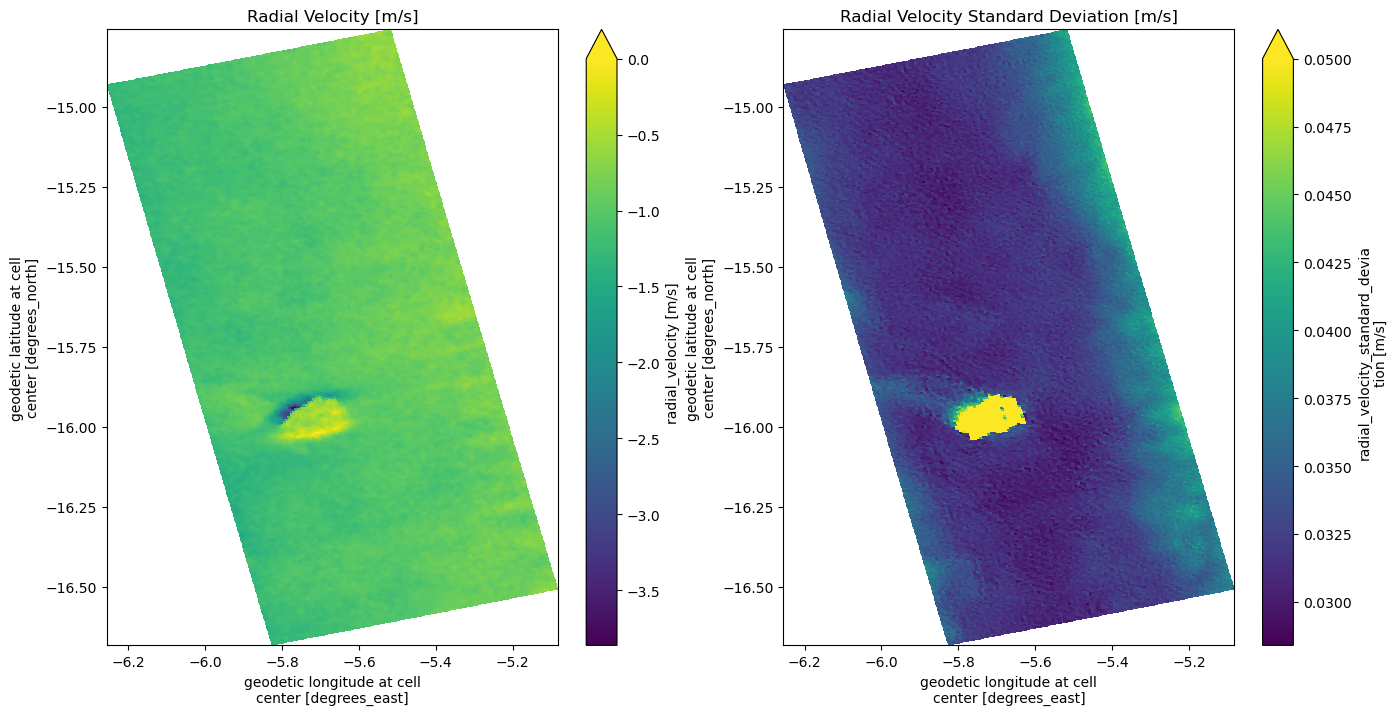

In [16]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
rvl.measurements.radial_velocity.plot(x="longitude", y="latitude", vmax=0, ax=ax[0])
rvl.measurements.radial_velocity_standard_deviation.plot(
    x="longitude", y="latitude", ax=ax[1], vmax=0.05
)
ax[0].set_title("Radial Velocity [m/s]")
ax[1].set_title("Radial Velocity Standard Deviation [m/s]")
plt.show()

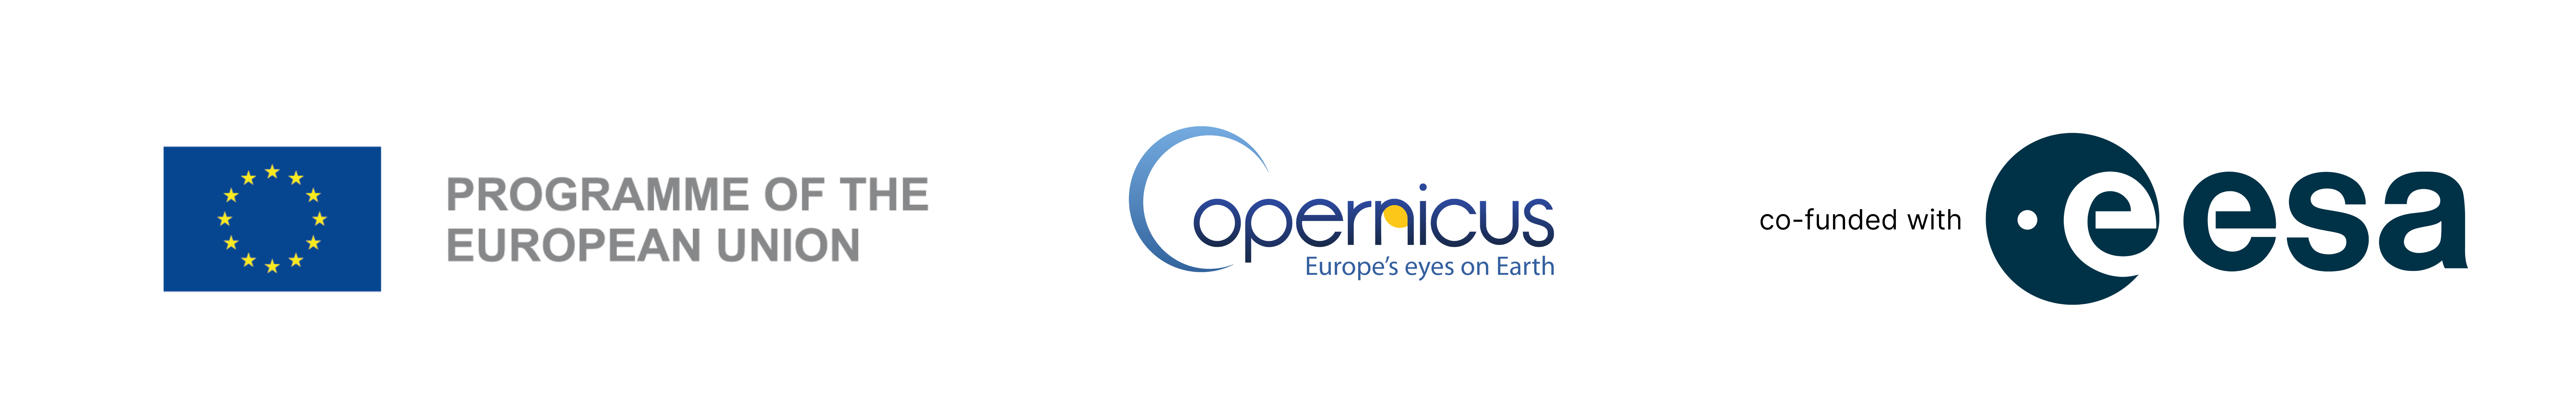